<a href="https://colab.research.google.com/github/rhausman/brain_tumor_analysis/blob/main/Tumor_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Research Question and Data Source

I will be using the following dataset from Kaggle for this project: `navoneel/brain-mri-images-for-brain-tumor-detection`. The dataset contains roughly 250 MRI scans of brains which either do or do not contian tumors, with simple binary labels indicating the presence or absence of a tumor. As we'll see later in the project, the dataset is far too small to be practical, and this became a significant issue when trying to train more complex models. However, I chose the dataset because of the clear clinical problem to which it corresponds, as well as some secondary scientific questions that it allows us to investigate. 

It is important to note that the dataset contains scans from various "depth slices" within the brain, so they vary considerably in their structure.

The plan was as follows:

1. Create a simple Binary Classification neural network. This classification task, along with the corresponding segmentation task, are supported by the literature. (Bhandari et al, 2020)

2. Create a simple Convolutional Autoencoder (AE), with the goal of being able to generate realistic examples of MRIs containing tumors.

3. Create, as an extension of the previous model, a **Variational Autoencoder with a disentangled latent space variable for "tumor presence"**. The idea of disentangling latent variables is a fantastic experiment with robust results in, for example, the problem of face generation. (Nakagawa et al, 2020) 

4. Then, perform a visualization of the latent space using UMAP or t-SNE to verify that it worked. This is an interesting route of investigation because, were more labels available, it would allow us to disentangle more latent variables and to determine, via analysis of the learned latent space and manipulation of the disentangled variables, which **other** factors the model considers useful in determining, for example, whether a tumor is malignant or not. There are a number of additional lables that could be useful in a hypothetical study such as this one, including genetic markers, age and demographic information, and features extracted via image/signal processing. Unfortunately, this data either was not available or were not feasible for me in the given timespan.


## Sources:
Bhandari, A., Koppen, J., & Agzarian, M. (2020). Convolutional neural networks for brain tumour segmentation. Insights into Imaging, 11(1), 77. https://doi.org/10.1186/s13244-020-00869-4

Nakagawa, N., Togo, R., Ogawa, T., & Haseyama, M. (2020). Face synthesis via user manipulation of disentangled latent representation. 2020 IEEE 9th Global Conference on Consumer Electronics (GCCE), 692–693. https://doi.org/10.1109/GCCE50665.2020.9291992



## Imports

In [1]:
!pip install torchtest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
#from sklearn.model_selection import train_test_split 

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch._C import NoneType
from torchtest import assert_vars_change

import os
from math import sqrt
import time
from copy import deepcopy
import skimage 
from skimage import io
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
import plotly.express as px
import plotly.figure_factory as ff
from matplotlib import pyplot as plt 

from PIL import Image
from IPython.display import clear_output
# set seed for reproducability
torch.manual_seed(42)

## Get the data

In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"
%cd /content/drive/MyDrive/kaggle/
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection --unzip
""" MORE DATA OPTIONS:
!kaggle competitions download -c hpa-single-cell-image-classification # whole cell image thing

!kaggle datasets download -d dschettler8845/human-protein-atlas-yellow-cell-tile-dataset
"""

/content/drive/MyDrive/kaggle
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


' MORE DATA OPTIONS:\n!kaggle competitions download -c hpa-single-cell-image-classification # whole cell image thing\n\n!kaggle datasets download -d dschettler8845/human-protein-atlas-yellow-cell-tile-dataset\n'

In [ ]:
os.listdir()

['kaggle.json',
 'human-protein-atlas-yellow-cell-tile-dataset.zip',
 'brain_tumor_dataset',
 'no',
 'yes',
 'brain-mri-images-for-brain-tumor-detection.zip',
 '1676335239.pt',
 '1676336668.pt',
 '1676337773.pt',
 '1676339293.pt',
 '1676341225.pt',
 '1676341575.pt',
 '1676342570.pt',
 '1676343146.pt',
 '1676354204.pt',
 '1677558439.pt',
 '1677600789.pt',
 '1677601472.pt',
 '1677603110.pt',
 '1677611569.pt',
 '1677613092.pt',
 '1677614061.pt',
 '1677614140.pt',
 '1677614743.pt',
 '1677614811.pt',
 '1677615045.pt',
 '1677615995.pt',
 '1677616546.pt',
 '1678047583_ae.pt',
 '1678048679_ae.pt',
 '1678049426_cls.pt',
 '1678049683_cls.pt',
 '1678056135_ae.pt',
 '1678056510_ae.pt',
 '1678058340_ae.pt',
 '1678058246_ae.pt',
 '1678058391_ae.pt',
 '1678058632_ae.pt',
 '1678058854_ae.pt',
 '1678059205_ae.pt',
 '1678060474_ae.pt',
 '1678061347_ae.pt',
 '1678061665_ae.pt',
 '1678061984_ae.pt',
 '1678062047_ae.pt']

## Notes
* Remove InvertColor transforms
* Try using PCA to visualize the latent space. See if it separates the classes.

## Set up Dataset

### Notes:
Here is the custom dataset I built for the project. It's design is fundamentally simple - it efficiently loads images from the appropriate directory and pairs it with its label. It also includes several transforms for minor data augmentation, which helped to mitigate the issues associated with the small size of my dataset (mostly; it was prone to overfitting).

I experimented with using a `RandomInvert()` transform as an additional data augmentation method. However, because such images never actually turn up, it's more sensible just to let the model use some simple landmarks and assumptions, such as the corners of the images always being dark, to learn a task more quickly.

The dataset also allows for normalization, with mean zero and standard deviation 1. I do it inside the dataset so that the models don't need to calculate BatchNorms during training, as I thought that might significantly bog down my limited computing power.

In [4]:
DEFAULT_RES = 200
class MyDataSet(Dataset):
  def __init__(self, pos_dir: str, neg_dir: str, transform=None, res:int=DEFAULT_RES):
    self.res = res
    self.pos_dir = pos_dir
    self.neg_dir = neg_dir
    self.transform = transform
    self.pos_filenames = [ os.path.join(pos_dir, x) for x in os.listdir(pos_dir)]
    self.neg_filenames = [ os.path.join(neg_dir, x) for x in os.listdir(neg_dir)]

    if not self.transform: # kind of need one. 
      self.transform_list = [
          transforms.Resize([res, res]), # maybe should make this bigger
          transforms.RandomHorizontalFlip(),
          transforms.RandomVerticalFlip(),
          #transforms.RandomRotation(15),
          #transforms.RandomInvert(),
          transforms.ToTensor(),
          #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
          ]
      self.transform = transforms.Compose(self.transform_list)
  
  def get_mean_and_std(self):
    loader = DataLoader(self, batch_size=10, num_workers=1, shuffle=False)
    mean = 0.
    std = 0.
    nb_samples = 0.
    for _data in loader:
        data = _data[0]
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples
    mean /= nb_samples
    std /= nb_samples
    return mean, std
  
  def set_up_normalization(self, mean, std):
    self.transform_list.append(transforms.Normalize(mean=(mean), std=(std)))
    self.transform = transforms.Compose(self.transform_list)
    print("Normalization added to transform")
    
    """
    # between -1 and 1?
    self.transform_list.append(transforms.Lambda( lambda x: ((x/torch.max(x)) -0.5)*2 ))
    self.transform = transforms.Compose(self.transform_list)
    print("Normalization added to transform")
    """
    

  def __len__(self):
    return len(self.pos_filenames) + len(self.neg_filenames)

  def __getitem__(self, x):
    #print("Index: ", x)
    img = None
    tumor = None
    if x < len(self.neg_filenames): # return a negative
      img = self.get_single_image(self.neg_filenames[x])
      tumor = 0
    else: # return a positive
      img = self.get_single_image(self.pos_filenames[x%len(self.neg_filenames)])
      tumor = 1
    img = img.convert('L')
    if self.transform:
      #print("transforming. shape before", img.size)
      img = self.transform(img)
      #print("shape after", img.size)
    if img is None:
      print("Problem: ", x%len(self.neg_filenames), self.pos_filenames[x%len(self.neg_filenames)])
    #print(img.size())
    return img, tumor

  # filename should be absolute path
  def get_single_image(self, filename):
    img = Image.open(filename)#io.imread(filename)
    if img is None:
      print("YO: ", filename)
    return img

## View Samples to see if it's working

Let's take a look at some example images

Normalization added to transform
torch.Size([1, 200, 200])


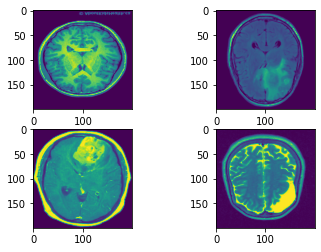

In [5]:
def show_batch(batch):
  batch = batch[0]
  f, axarr = plt.subplots(2,2)
  print(batch[0].size())
  batch = [ np.squeeze(t.numpy(), axis=0) for t in batch ]
  axarr[0][0].imshow(batch[0])
  axarr[0][1].imshow(batch[1])
  axarr[1][0].imshow(batch[2])
  axarr[1][1].imshow(batch[3])
  #print(batch, type(batch))

ds = MyDataSet(pos_dir = "/content/drive/MyDrive/kaggle/brain_tumor_dataset/yes", neg_dir="/content/drive/MyDrive/kaggle/brain_tumor_dataset/no")
mean, std = ds.get_mean_and_std() # set up normalization with the same mean and td overall for each
ds.set_up_normalization(mean, std)
dl = DataLoader(ds, batch_size=4, shuffle=True, num_workers=0) # for now no extra workers

for i, batch in enumerate(dl):
  if i ==4:
    show_batch(batch)
    break

# Classifier

## Model Definition - Classifier

This model uses a fairly simple architecture: 

1. Two convolution and MaxPooling Layers
2. Several Linear layers
3. A Sigmoid activation function
4. Binary Crossentropy loss, for the binary classification task.

In [6]:
# first I'll do a classifier
class Classifier(nn.Module):
  def __init__(self, res:int =DEFAULT_RES, confidence=0.75):
    super(Classifier, self).__init__()
    self.res = res
    self.confidence = confidence
    self.layers = []
    s = (1, self.res, self.res)

    self.layers.append(nn.Conv2d(1, 4, 5))
    s = 4, s[1] - 4, s[2]-4 # stride is 2 i believe
    self.layers.append(nn.MaxPool2d((2,2)))
    s = s[0], s[1]/2, s[2]/2
    self.layers.append(nn.Conv2d(4, 8, 10))
    s = 8, s[1]-9, s[2] - 9
    self.layers.append(nn.MaxPool2d(2))
    s = s[0], (s[1]-1)/2, (s[2]-1)/2
    self.layers.append(nn.Flatten())
    s = s[0]*s[1]*s[2], None
    self.layers.append(nn.Linear( int(s[0]), 120))
    #self.layers.append(nn.ReLU())
    self.layers.append(nn.Linear(120, 60) )
    #self.layers.append(nn.ReLU())
    self.layers.append(nn.Linear(60,20))
    #self.layers.append(nn.ReLU())
    self.layers.append(nn.Linear(20, 1))
    self.layers.append(nn.Sigmoid())
    #self.layers = [self.conv1, self.pool1, self.conv2, self.pool2, self.flatten, self.l1, self.l2, self.l3, self.l4, self.sigmoid]
    # dropout?
    self.seq = nn.Sequential(*self.layers)

  def forward(self, x):
    #print("input shape: ", x.shape)
    #for i, layer in enumerate(self.layers):
    #  x = layer(x) #F.relu(layer(x))
      #print(f"{i} shape: {x.shape}")
    x = self.seq(x)
    return x # get in batch format
  
  def inference(self, x):
    out = self.forward(x)
    out = out > self.confidence
    return out

## Training

In [ ]:
# constants
epochs = 40

# data
ds = MyDataSet(pos_dir = "/content/drive/MyDrive/kaggle/brain_tumor_dataset/yes", neg_dir="/content/drive/MyDrive/kaggle/brain_tumor_dataset/no")
mean, std = ds.get_mean_and_std() # set up normalization with the same mean and td overall for each
ds.set_up_normalization(mean, std)
_m, _s = ds.get_mean_and_std()
print(f"After adding normalization, the mean and std of pixel brightness are {_m.item()} and {_s.item()}, whereas before they were {mean.item()} and {std.item()}.")
train_set, test_set = random_split(ds, [0.8, 0.2], generator=torch.Generator().manual_seed(42)) # manual seed for reproducible result right now

print(f"Train set: {len(train_set)}, Test set: {len(test_set)}")
train_loader = DataLoader(train_set, batch_size=12, shuffle=True, num_workers=2) # for now no extra workers
test_loader = DataLoader(test_set, batch_size=12, shuffle = False, num_workers=2)

# save info
model_save_name = str(int(time.time())) + "_cls.pt" # unique name
save_path = f"/content/drive/MyDrive/kaggle/{model_save_name}"
print("Training model at ", model_save_name)

Normalization added to transform
After adding normalization, the mean and std of pixel brightness are 4.758948080052505e-08 and 1.0, whereas before they were 0.2620930075645447 and 0.22116468846797943.
Train set: 203, Test set: 50
Training model at  1678071270_cls.pt


Epoch 30 train loss: 1.9447893886826932
 test loss: 3.1381235273547645


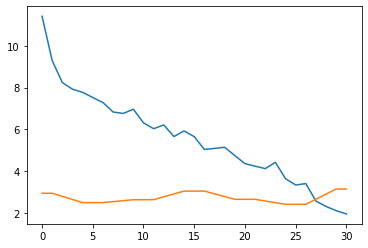

KeyboardInterrupt: ignored

In [ ]:
net = Classifier()
loss_fxn = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-7) 

train_losses = []
test_losses = []
for epoch in range(epochs):

  running_loss = 0.
  for i, batch in enumerate(train_loader):
    X, y = batch
    optimizer.zero_grad()
    output = net(X)
    output = torch.squeeze(output, 1)
    loss = loss_fxn(output, y.float())
    loss.backward() # retain_graph=True for multi losses?
    optimizer.step()

    #print(f"Output: {output}, labels: {y}, loss: {loss.item()}")
    #stats
    running_loss += loss.item()
  # save model each epoch
  torch.save(net.state_dict(), save_path)
  train_losses.append(running_loss)
  # see the validation loss
  if epoch % 5 == 0:
    net.eval()
    with torch.no_grad():
      test_loss = 0.
      for i, batch in enumerate(test_loader):
        X, y = batch 
        output = net(X)
        output = torch.squeeze(output, 1)
        loss = loss_fxn(output, y.float())
        test_loss += loss.item()
      if len(test_losses) > 0:
        fill_losses = np.linspace(test_losses[-1], test_loss, 4)
        test_losses.extend(list(fill_losses))
      test_losses.append(test_loss)
    net.train()
    
  # Display output!
  clear_output(wait=True)
  print(f"Epoch {epoch} train loss: {train_losses[-1]}\n test loss: {test_losses[-1]}")
  plt.plot(train_losses)
  plt.plot(test_losses)
  plt.show()


## Validation 

* Validate on train and validation data to see if the issue is overfitting or mere underperformance/underfitting

* The performance on both test (shown first) and train data is fairly good, with an AUC of 0.82 for test and 1 for train.

* The disparity in AUC demonstrates that there is a small amount of overfitting happening, but not to a fatal degree.

* ** Note that '0' means "no tumor" and '1' means "tumor is present". **

* Normally, to address the overfitting, I would use Dropout in my model, but I was reluctant to do so because of the very small size of my dataset.

In [ ]:
desired_model_name = None #'1676354204.pt'
desired_model_path = os.path.join("/content/drive/MyDrive/kaggle", sorted([ x for x in os.listdir() if "_cls.pt" in x ])[-1] if desired_model_name is None else desired_model_name)
print('Selected model for evaluation: ', desired_model_path)

Selected model for evaluation:  /content/drive/MyDrive/kaggle/1678049683_cls.pt


In [ ]:
net = Classifier()
net.load_state_dict(torch.load(desired_model_path))
net.confidence = 0.5
net.eval()

def evaluate(model, loader):
  all_preds = []
  all_labels = []
  for i, batch in enumerate(loader):
    X, y = batch
    out = model(X)
    all_preds += list(out.detach().squeeze(1).numpy())
    all_labels += list(y.numpy())
  
  
  all_preds_binary = np.array(all_preds) > net.confidence
  all_labels = np.array(all_labels)
  f_neg, f_pos, t_neg, t_pos = (np.logical_and(all_preds_binary==0, all_labels==1).sum(), 
                              np.logical_and(all_preds_binary==1, all_labels==0).sum(), 
                              np.logical_and(all_preds_binary==0, all_labels==0).sum(), 
                              np.logical_and(all_preds_binary==1, all_labels==1).sum()
                              )
  n = float(len(all_labels))
  print(f"False negatives: {f_neg} ({100*f_neg/n}% of total)")
  print(f"False positives: {f_pos} ({100*f_pos/n}% of total)")
  print(f"True negatives:  {t_neg} ({100*t_neg/n}% of total)")
  print(f"True positives:  {t_pos} ({100*t_pos/n}% of total)")

  # ROC curve
  #breakpoint()
  #breakpoint()
  binary_converter = LabelBinarizer().fit( list(all_labels) + [2])
  y_onehot = binary_converter.transform( np.array(list(all_labels)))
  y_score = all_preds
  pos_class = "Tumor present"
  class_id = 1 #np.flatnonzero(binary_converter.classes_ == pos_class)[0]
  RocCurveDisplay.from_predictions(
    y_onehot[:, class_id],
    np.array(y_score),
    name= pos_class,
    color="darkorange",
  )
  plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
  plt.axis("square")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve for Tumor Detection")
  plt.legend()
  plt.show()

  # confusion matrix. Vertical axis is label, horizontal is prediction
  z = [[t_neg, f_pos], [f_neg, t_pos]]
  z_text = [[str(val) for val in row] for row in z]
  axis_labels = ["No Tumor", "Tumor"]
  fig = px.imshow(z, text_auto=True, title="Confusion Matrix", ) #ff.create_annotated_heatmap(z, x=axis_labels, y=axis_labels, annotation_text = z_text)
  #fig.update_layout(title_text='<b>Confusion Matrix</b>', )
  fig.update_xaxes(title="Prediction")
  fig.update_yaxes(title="Actual Value")
  fig.show()


False negatives: 5 (10.0% of total)
False positives: 5 (10.0% of total)
True negatives:  11 (22.0% of total)
True positives:  29 (58.0% of total)


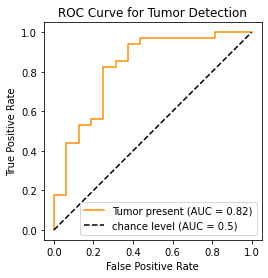

In [ ]:
evaluate(net, test_loader)

False negatives: 1 (0.49261083743842365% of total)
False positives: 0 (0.0% of total)
True negatives:  82 (40.39408866995074% of total)
True positives:  120 (59.11330049261084% of total)


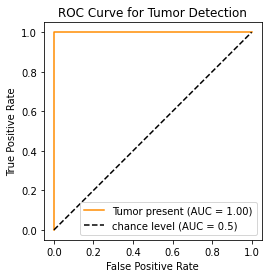

In [ ]:
evaluate(net, train_loader)

# AutoEncoder

## AutoEncoder Model

Goals:

* Create a model that can reconstruct based on point in latent space
* Disentangle a dimension of the latent space for tumor presence
* Try to disentangle other dimensions in an unsupervised way

Note that the class name "VAE" is a misnomer here because I did not have the time to actually make it a variational autoencoder so this is just a normal autoencoder. I believe that making it a VAE would have resulted in significantly better reconstructions, but it would have required implementing a KL-divergence loss and the reparameterization procedure.

In [11]:
# first I'll do a classifier
class VAE(nn.Module):
  def __init__(self, res:int =DEFAULT_RES, confidence=0.75):
    super(VAE, self).__init__()
    self.res = res
    self.reshape = 1, 4, 8 # channels for managing conv layers
    self.confidence = confidence
    self.encoder_conv, self.encoder_linear = [], []
    self.decoder_linear, self.decoder_conv = [], []

    s = (1, self.res, self.res)

    def app(l):
      self.decoder_linear.append(l) 

    self.encoder_conv.append(nn.Conv2d(1, 4, 5))
    self.encoder_conv.append(nn.ReLU())
    s = 4, s[1] - 4, s[2]-4 # stride is 2 i believe
    self.encoder_conv.append(nn.MaxPool2d((2,2)))
    self.encoder_conv.append(nn.ReLU())
    s = s[0], s[1]/2, s[2]/2
    self.encoder_conv.append(nn.Conv2d(4, 8, 10))
    self.encoder_conv.append(nn.ReLU())
    s = 8, s[1]-9, s[2] - 9
    self.encoder_conv.append(nn.MaxPool2d(2))
    self.encoder_conv.append(nn.ReLU())
    s = s[0], (s[1]-1)/2, (s[2]-1)/2
    self.flatten = nn.Flatten()
    s = s[0]*s[1]*s[2], None
    self.encoder_linear.append(nn.Linear( int(s[0]), 120))
    self.encoder_linear.append(nn.ReLU())
    self.encoder_linear.append(nn.Linear(120, 60) )
    
    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(8,44,44))

    self.encoder_conv = nn.Sequential(*self.encoder_conv)
    self.encoder_linear = nn.Sequential(*self.encoder_linear)

    def app(l):
      self.decoder_linear.append(l)
    app(nn.Linear(60,120))
    app(nn.ReLU())
    app(nn.Linear(120, int(s[0])) )
    app(nn.ReLU())
    self.decoder_linear = nn.Sequential(*self.decoder_linear)

    def app(l):
      self.decoder_conv.append(l)
    #app(nn.Upsample(size=(121,121))) #scale_factor=1.1)) #size=() ))
    app(nn.ConvTranspose2d(8, 4, 10, padding=2, output_padding=1, stride=2))
    app(nn.ReLU())
    app(nn.Upsample(size=(100, 100)))
    app(nn.ReLU())
    app(nn.ConvTranspose2d(4,1, 5, padding=2, output_padding=1, stride=2))

    self.decoder_conv = nn.Sequential(*self.decoder_conv)
    # Ideas: add batch norm!
    # add ReLU or sigmoid, or without it.
    # need to de-normalize output to visualize
    #self.layers = [self.conv1, self.pool1, self.conv2, self.pool2, self.flatten, self.l1, self.l2, self.l3, self.l4, self.sigmoid]
    # dropout?
    # self.seq = nn.Sequential(*self.layers)

    # TEMP 1
    amt = 50*50
    self.tmp1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(amt, int(amt/10)),
        nn.ReLU(),
        nn.Linear(int(amt/10),amt),
        nn.Linear(amt,amt),
        nn.Unflatten(dim=1, unflattened_size=(50,50))
                              )

  def forward(self, x):
    
    latent = self.encode(x)
    #reconstruction = self.decode(x)
    reconstruction = self.decode(latent)
    return reconstruction # activation fxn. Keep in mind we'll have to transform since input was normalized, gotta transform output to compensate
     # TODO UNCOMMENT
    #x = self.tmp1(x)
    #return torch.sigmoid(x)
    

  
  def encode(self, x):
    x = self.encoder_conv(x)
    #print(f"Shape after conv: {x.shape}")
    x = self.flatten(x)
    #print(f"Shape after flattening: {x.shape}")
    return self.encoder_linear(x)
  
  def decode(self, x):
    #x = torch.relu(self.decoder[0](x))
    #x = torch.relu(self.decoder[1](x))
    x = self.decoder_linear(x)
    #x = x.view(x.shape[0], 8, 44, 44) # reshape
    x = self.unflatten(x)
    x = self.decoder_conv(x)
    #print("x shape: ", x.shape)
    # todo decode linear
    # todo activation?
    return x #torch.sigmoid(x)

  def inference(self, x, mean=0, std=1):
    out = self.forward(x)
    #return out.mul(std).add(mean)
    return out

## Train Autoencoder

In [7]:
# helper fxns
def show_batch(batch, n=None):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(batch.shape)
  if n is not None:
    batch = batch[:n]
  sidelen = int(sqrt(len(batch)))+1
  f, axarr = plt.subplots(sidelen,sidelen)
  #print(batch[0].size())
  batch = [ np.squeeze(t.cpu().detach().numpy() , axis=0) if 1 in t.shape else t.cpu().detach().numpy() for t in batch ]
  for i in range(sidelen):
    for j in range(sidelen):
      index = (sidelen*i)+j
      if index >= len(batch):
        break
      axarr[i][j].imshow(batch[index])

In [8]:
# constants
epochs = 100

# data
ds = MyDataSet(pos_dir = "/content/drive/MyDrive/kaggle/brain_tumor_dataset/yes", neg_dir="/content/drive/MyDrive/kaggle/brain_tumor_dataset/no", res=200) #50
mean, std = ds.get_mean_and_std() # set up normalization with the same mean and td overall for each
ds.set_up_normalization(mean, std)
train_set, test_set = random_split(ds, [0.8, 0.2], generator=torch.Generator().manual_seed(42)) # manual seed for reproducible result right now

print(f"Train set: {len(train_set)}, Test set: {len(test_set)}")
train_loader = DataLoader(train_set, batch_size=10, shuffle=True, num_workers=2) # for now no extra workers
test_loader = DataLoader(test_set, batch_size=10, shuffle = False, num_workers=0)

# save info
model_save_name = str(int(time.time())) + "_ae.pt" # unique name
save_path = f"/content/drive/MyDrive/kaggle/{model_save_name}"
print("Training model at ", model_save_name)

Normalization added to transform
Train set: 203, Test set: 50
Training model at  1678075672_ae.pt


### Unconditioned Latent Space

Epoch 195 train loss: 11.018891483545303
 test loss: 3.031747579574585, batch size: torch.Size([3, 1, 200, 200])


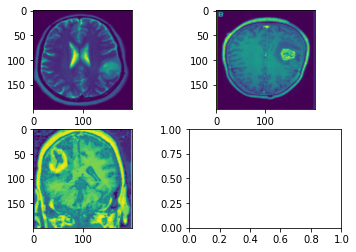

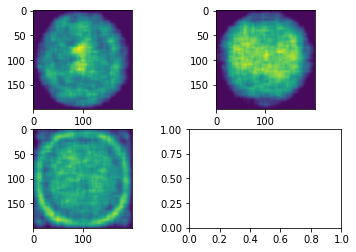

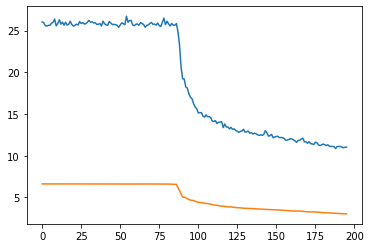

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = VAE()
net = net.to(device) # todo remove

loss_fxn = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9) # weight_decay = 1e-5 # todo 0.001 learning rate

train_losses = []
test_losses = []


epochs = 400
for epoch in range(epochs):
  net.train()
  running_loss = 0.
  for i, batch in enumerate(train_loader): #enumerate(train_loader):
    X, y = batch
    X = X.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    output = net(X)
    output = torch.squeeze(output, 1)
    loss = loss_fxn(output, torch.squeeze(X))
    loss.backward() # retain_graph=True for multi losses?
    optimizer.step()

    running_loss += loss.item()
    """"""
    

    #print(f"Output: {output}, labels: {y}, loss: {loss.item()}")
    #stats


  # save model each epoch
  train_losses.append(running_loss)
  """ TODO REMOVE """
  if epoch % 5 != 0: # gotta remove these lines
    continue # next epoch
  torch.save(net.state_dict(), save_path)

  # see the validation loss
  net.eval()
  with torch.no_grad():
    test_loss = 0.
    for i, val_batch in enumerate(test_loader): #enumerate(test_loader): # todo CHANGE THIS BACK
      X, y = val_batch 
      X = X.to(device)
      y = y.to(device)

      output = net(X)
      output = torch.squeeze(output, 1)
      loss = loss_fxn(output, torch.squeeze(X))
      test_loss += loss.item()
    if len(test_losses) > 0:
      test_losses.extend(list(np.linspace(test_losses[-1], test_loss, 5)))
    else:
      test_losses.append(test_loss) # TODO: SHOULD BE DEFAULT
    """"""
    #show_batch(X)
    #show_batch(net.inference(X))
    show_batch(batch[0]) # TODO REMOVE THESE 2 LINES
    show_batch(net.inference(batch[0].to(device)))
    
  # Display output!
  clear_output(wait=True)
  print(f"Epoch {epoch} train loss: {train_losses[-1]}\n test loss: {test_losses[-1]}, batch size: {batch[0].shape}")
  fig, ax = plt.subplots()
  ax.plot(train_losses)
  ax.plot(test_losses)
  plt.show()


### Visualize Reconstructions

Selected model for evaluation:  /content/drive/MyDrive/kaggle/1678072800_ae.pt
torch.Size([10, 1, 200, 200])
torch.Size([10, 1, 200, 200])


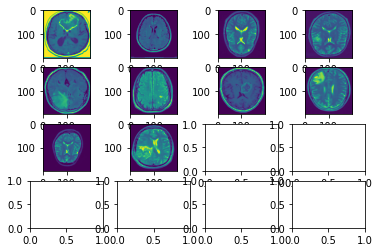

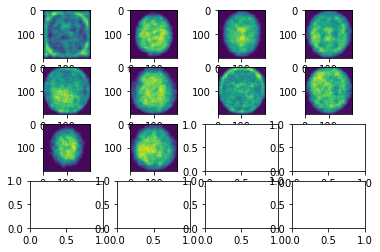

In [27]:
desired_model_name = "1678072800_ae.pt" #"1678071854_ae.pt"
desired_model_path = os.path.join("/content/drive/MyDrive/kaggle", sorted([ x for x in os.listdir() if "_ae.pt" in x ])[-1] if desired_model_name is None else desired_model_name)
print('Selected model for evaluation: ', desired_model_path)
model = VAE()
model.load_state_dict(torch.load(desired_model_path))
model.eval()
    
for i, batch in enumerate(test_loader):
  X, y = batch
  latent = model.encode(X)
  out = model.decode(latent)
  #all_preds += list(latent[:,0].detach().squeeze(0).numpy())
  #all_labels += list(y.numpy())

  if i == 0:
    show_batch(X)
    show_batch(out)

### Brief Remarks

For whatever reason, the above model (repeatedly) took a long time before starting to converge and learn effectively. Its reconstructions were never of very high quality, and **notably, it is generally unable to reconstruct tumors very well**, though I am not able to back this up quantitatively because I don't have a metric by which to measure this. I observed that while normal cranial structures, such as the slight separation between the brain and the skull (look at the structural similarity between the bottom-left original image and its reconstruction), are replicated well by the model, anomolies such as tumors are **not** replicated properly. Again, in both the bottom left and top right images, there are tumors present in the original images but not in the reconstructions. By contrast, the top left image (devoid of any tumor), still has the corpus callosum faintly present in the reconstruction because it is a normal part of the brain, so the model learned that it should be present.

### Conditioned Latent Space

Epoch 330 train loss: 8.392379760742188
 test loss: 20.839012652635574, batch size: torch.Size([3, 1, 200, 200])


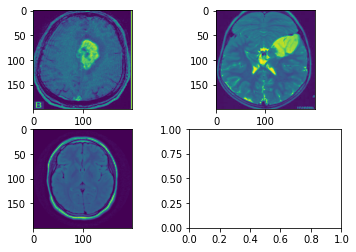

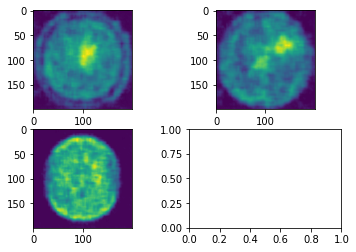

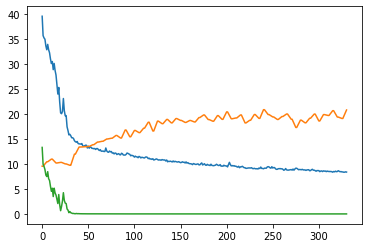

LATENT LOSS VALIDATION: 0.2160755693912506
LATENT LOSS: 9.892903472064063e-05


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = VAE()
net = net.to(device) # todo remove

reconstruction_loss_fxn = nn.MSELoss()
latent_loss_fxn = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9) # weight_decay = 1e-5 # todo 0.001 learning rate

train_losses = []
test_losses = []
latent_losses = []

epochs = 400
latent_weight = 10.
for epoch in range(epochs):
  net.train()
  running_loss = 0.
  running_latent_loss = 0.
  for i, batch in enumerate(train_loader): #enumerate(train_loader):
    X, y = batch
    X = X.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    latent = net.encode(X)
    reconstruction = net.decode(latent)
    reconstruction = torch.squeeze(reconstruction, 1)

    latent_loss = latent_loss_fxn(latent[:,0], y.float() )
    reconstruction_loss = reconstruction_loss_fxn(reconstruction, torch.squeeze(X))
    loss = latent_loss + reconstruction_loss
    loss.backward() # retain_graph=True for multi losses?
    optimizer.step()

    running_loss += loss.item()
    running_latent_loss += latent_loss.item()
    """"""
    

    #print(f"Output: {output}, labels: {y}, loss: {loss.item()}")
    #stats


  # save model each epoch
  train_losses.append(running_loss)
  latent_losses.append(running_latent_loss)
  
  print(f"LATENT LOSS: {latent_loss.item()}")
  if epoch % 5 != 0: # gotta remove these lines
    continue # next epoch
  torch.save(net.state_dict(), save_path)

  # see the validation loss
  net.eval()
  with torch.no_grad():
    test_loss = 0.
    for i, val_batch in enumerate(test_loader): #enumerate(test_loader): # todo CHANGE THIS BACK
      X, y = val_batch 
      X = X.to(device)
      y = y.to(device)

      latent = net.encode(X)
      reconstruction = net.decode(latent)
      reconstruction = torch.squeeze(reconstruction, 1)

      latent_loss = latent_loss_fxn(latent[:,0], y.float())
      reconstruction_loss = reconstruction_loss_fxn(reconstruction, torch.squeeze(X))
      test_loss += latent_loss.item() + reconstruction_loss.item()
    if len(test_losses) > 0:
      test_losses.extend(list(np.linspace(test_losses[-1], test_loss, 5)))
    else:
      test_losses.append(test_loss) # TODO: SHOULD BE DEFAULT
    """"""
    #show_batch(X)
    #show_batch(net.inference(X))
    show_batch(batch[0]) # TODO REMOVE THESE 2 LINES
    show_batch(net.inference(batch[0].to(device)))
    
  # Display output!
  clear_output(wait=True)
  print(f"Epoch {epoch} train loss: {train_losses[-1]}\n test loss: {test_losses[-1]}, batch size: {batch[0].shape}")
  fig, ax = plt.subplots()
  ax.plot(train_losses)
  ax.plot(test_losses)
  ax.plot(latent_losses)
  plt.show()
  print(f"LATENT LOSS VALIDATION: {latent_loss.item()}")


## Analysis of training

## Validation and analysis

Below we can see (for validation data, then train data), both reconstructions and the model's performance on the binary classification task. Classification inference was done by extracting the appropriate variable from the latent space. While it appears that the model overfit the classification task slightly more than the dedicated classificaiton model, I am confident that it could achieve similar results given more training time. In addition, the difference in reconstruction (compared to the unconditioned latent space model) is night and day with respect to tumors being present in the reconstruction when they are present in the original image.

While this is not the most exciting development in the context of this task, it suggests that we can help models train more effectivley on limited data by "suggesting" certain features to them that we think could be useful in generating a reconstruction that is of high quality with respect to the features that we care about (e.g. tumors). This is an interesting avenue for more investigation.

In [37]:
desired_model_name = None #'1676354204.pt'
desired_model_path = os.path.join("/content/drive/MyDrive/kaggle", sorted([ x for x in os.listdir() if "_ae.pt" in x ])[-1] if desired_model_name is None else desired_model_name)
print('Selected model for evaluation: ', desired_model_path)

Selected model for evaluation:  /content/drive/MyDrive/kaggle/1678073868_ae.pt


In [40]:
net = VAE()
net.load_state_dict(torch.load(desired_model_path))
net.confidence = 0.5
net.eval()

def evaluate(model, loader):
  all_preds = []
  all_labels = []
  for i, batch in enumerate(loader):
    X, y = batch
    latent = model.encode(X)
    out = model.decode(latent)
    all_preds += list(latent[:,0].detach().squeeze(0).numpy())
    all_labels += list(y.numpy())

    if i == 0:
      show_batch(X)
      show_batch(out)
  
  
  all_preds_binary = torch.sigmoid(torch.Tensor(all_preds)).numpy() > net.confidence
  all_labels = np.array(all_labels)
  f_neg, f_pos, t_neg, t_pos = (np.logical_and(all_preds_binary==0, all_labels==1).sum(), 
                              np.logical_and(all_preds_binary==1, all_labels==0).sum(), 
                              np.logical_and(all_preds_binary==0, all_labels==0).sum(), 
                              np.logical_and(all_preds_binary==1, all_labels==1).sum()
                              )
  n = float(len(all_labels))
  print(f"False negatives: {f_neg} ({100*f_neg/n}% of total)")
  print(f"False positives: {f_pos} ({100*f_pos/n}% of total)")
  print(f"True negatives:  {t_neg} ({100*t_neg/n}% of total)")
  print(f"True positives:  {t_pos} ({100*t_pos/n}% of total)")

  # ROC curve
  #breakpoint()
  #breakpoint()
  binary_converter = LabelBinarizer().fit( list(all_labels) + [2])
  y_onehot = binary_converter.transform( np.array(list(all_labels)))
  y_score = all_preds
  pos_class = "Tumor present"
  class_id = 1 #np.flatnonzero(binary_converter.classes_ == pos_class)[0]
  RocCurveDisplay.from_predictions(
    y_onehot[:, class_id],
    np.array(y_score),
    name= pos_class,
    color="darkorange",
  )
  plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
  plt.axis("square")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve for Tumor Detection")
  plt.legend()
  plt.show()

  # confusion matrix. Vertical axis is label, horizontal is prediction
  z = [[t_neg, f_pos], [f_neg, t_pos]]
  z_text = [[str(val) for val in row] for row in z]
  axis_labels = ["No Tumor", "Tumor"]
  fig = px.imshow(z, text_auto=True, title="Confusion Matrix", ) #ff.create_annotated_heatmap(z, x=axis_labels, y=axis_labels, annotation_text = z_text)
  #fig.update_layout(title_text='<b>Confusion Matrix</b>', )
  fig.update_xaxes(title="Prediction")
  fig.update_yaxes(title="Actual Value")
  fig.show()


torch.Size([10, 1, 200, 200])
torch.Size([10, 1, 200, 200])
False negatives: 3 (6.0% of total)
False positives: 7 (14.0% of total)
True negatives:  9 (18.0% of total)
True positives:  31 (62.0% of total)


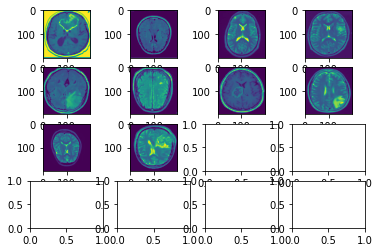

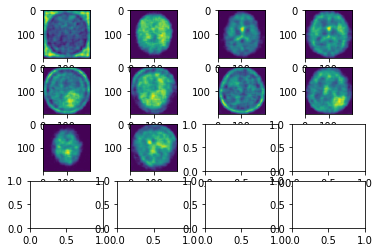

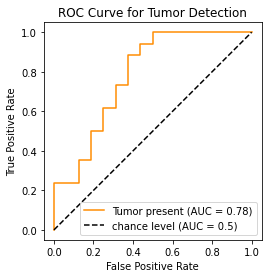

In [41]:
evaluate(net, test_loader)

torch.Size([10, 1, 200, 200])
torch.Size([10, 1, 200, 200])
False negatives: 0 (0.0% of total)
False positives: 0 (0.0% of total)
True negatives:  82 (40.39408866995074% of total)
True positives:  121 (59.60591133004926% of total)


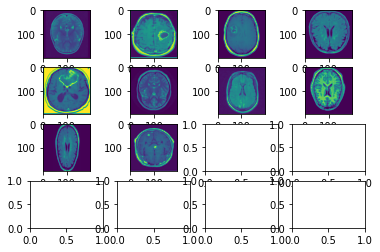

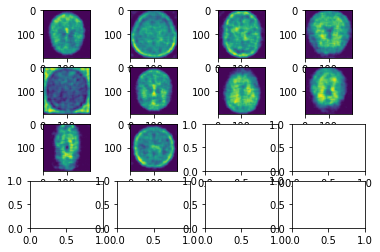

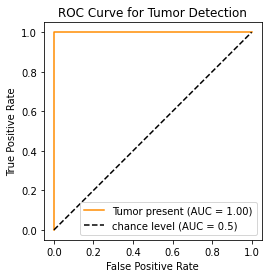

In [42]:
evaluate(net, train_loader)

### Latent Space Visualization

* Here I use TSNE to show a 2D projection of the latent representation of tumorless (blue) and tumor (yellow) samples.

* There is not quite as much separation as I expected, but some can certainly be seen.

In [46]:
from sklearn.manifold import TSNE 
import pandas as pd 

desired_model_name = None #'1676354204.pt'
desired_model_path = os.path.join("/content/drive/MyDrive/kaggle", sorted([ x for x in os.listdir() if "_ae.pt" in x ])[-1] if desired_model_name is None else desired_model_name)
print('Selected model for evaluation: ', desired_model_path)

net = VAE()
net.load_state_dict(torch.load(desired_model_path))
net.confidence = 0.5
net.eval()


all_preds = []
all_labels = []
all_latent = []
loader = train_loader 

with torch.no_grad():
  for i, batch in enumerate(loader):
    X, y = batch
    latent = model.encode(X)
    out = model.decode(latent)
    all_preds += list( torch.sigmoid(latent[:,0].detach().squeeze(0)).numpy() )
    all_labels += list(y.numpy())
    all_latent.extend([latent[i].numpy() for i in range(latent.shape[0])])



all_preds_binary = np.array(all_preds) > net.confidence
all_labels = np.array(all_labels)



Selected model for evaluation:  /content/drive/MyDrive/kaggle/1678073868_ae.pt


In [66]:
a = pd.DataFrame({'label': all_labels, 'prediction': all_preds})
b = pd.DataFrame(all_latent)
tsne = TSNE(n_components=2, random_state=0)
representation = tsne.fit_transform(b)

all = pd.concat([a, pd.DataFrame(representation)], axis=1)
px.scatter(all, x=0, y=1, color="label", color_discrete_map={0: "green", 1: "red"}).update_traces(mode="markers") #, hover_data="prediction")

In [62]:
all

,label,prediction,0,1
0,1,0.609548,13.215258,-8.621138
1,1,0.594217,7.215148,30.510750
2,1,0.019061,17.787891,55.167572
3,1,0.296889,24.713469,-16.705614
4,1,0.179954,29.964079,14.922140
...,...,...,...,...
198,0,0.721787,-19.306593,-54.282902
199,1,0.106416,15.466555,52.000450
200,1,0.099503,21.190187,-7.084954
201,1,0.469059,13.635193,8.007360
